In [1]:
#@title Import Tensorflow ->  GPU
import tensorflow as tf
import tensorflow_probability as tfp
tfd=tfp.distributions
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
#@title Imports and Visualization parameters
# import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import math
from typing import Any, Optional

from keras.models import Sequential
from keras.regularizers import L1L2
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.utils.vis_utils import plot_model
tf.random.set_seed(42)


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('seaborn-colorblind')
sns.set_theme()
%matplotlib inline

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
          'figure.titlesize': 'x-large',
          'figure.dpi': 150,
         'axes.labelsize': 'x-large',
         'axes.titlesize': 'x-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'savefig.bbox': 'tight'}

plt.rcParams.update(params)
# plt.rcParams.keys() ### Use to check the available parameters
#tf.debugging.set_log_device_placement(True) ### Use to debug use of GPU

# Data load

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%run 'drive/My Drive/MONTA/ts_modelling.py'

In [ ]:
df = pd.read_csv("drive/My Drive/MONTA/Spot_price_NO1.csv")
df = df[["price", "datetime"]]
df["datetime"] = pd.to_datetime(df["datetime"])
df.set_index("datetime", inplace = True)
data = df.iloc[:41592] # Keep untouched From October 2021


In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
# General data normalization
p_min = data.min()
p_max = data.max()
ndata = (data-p_min)/(p_max-p_min)

# Modelling

## Forecasting


Input (Kernel) regularization documentation: https://keras.io/api/layers/regularizers/

MAE (L1 Loss):  https://angela-wong.medium.com/rmse-or-mae-which-and-why-loss-functions-used-in-regression-and-classification-a98afc9fa215

Dense Variational represents:

[K, b] ~ Prior()

M = matmul(X, K) + b

Y ~ Likelihood(M)

In [ ]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [ ]:
train_size = 1968
test_size = 96
folds = 20
n_steps_in = 168
n_steps_out = 96
indexes=[]
preds = []
hists=[]
n_features = X.shape[2]
def prior_trainable(kernel_size: int, bias_size: int, dtype: Any) -> tf.keras.Model:
    """Specify the prior over 'keras.layers.Dense' 'kernel' and 'bias'."""
    n = kernel_size + bias_size
    
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])

def posterior_mean_field(kernel_size: int, bias_size: int, dtype: Any) -> tf.keras.Model:
    """Specify the posterior over 'keras.layers.Dense' 'kernel' and 'bias'."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-4 + tf.nn.softplus(c + t[..., n:])),  ### Softplus ("soft" ReLU to ensure the scale is in the positive range). t parameter is for broadcasting!
          reinterpreted_batch_ndims=1)),
  ])


def build_model():
    model = Sequential()
    model.add(LSTM(200,
                   input_shape=(n_steps_in, n_features),
                   return_sequences=True,
                   kernel_regularizer=L1L2(l1=0.001, l2=0.001)))
    model.add(Flatten())
    model.add(tf.keras.layers.Dense(n_steps_out+1))  # Output mean and different std.dev every time. (Mean and std.dev)
    model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(
                                          loc=t[..., :1],
                                          scale=0.0015 + tf.math.softplus(0.05 * t[..., 1:]))))  # Fit the standard deviation to the second term
    # model.add(tfp.layers.DenseVariational(n_steps_out,
    #                                       make_posterior_fn=posterior_mean_field, 
    #                                       make_prior_fn=prior_trainable)) # Since it is not a batch-like processing,
    #                               # the output needs to be of the correct time-steps.
    model.compile(optimizer='adam', loss=negloglik, metrics=['mae', 'mse']) # Negative loglikelihood.
    return model

model = build_model()

In [ ]:
train_size = 1968
test_size = 96
periods = 20
n_steps_in = 168
n_steps_out = 96
indexes=[]
dists = []
hists=[]
for ii, tr, te in datagen(train_size, test_size, periods):
    # Define data
    in_seq = ndata[tr:te].values
    x_input = ndata[te-n_steps_in:te].values  # Last sequence of in_seq, to use for prediction
    y_true = ndata[te:te+n_steps_out] # Values to be predicted
    # convert to [rows, columns] structure
    in_seq = in_seq.reshape((len(in_seq), 1))
    #in_seq2 = in_seq2.reshape((len(in_seq2), 1))
    #out_seq = out_seq.reshape((len(out_seq), 1))
    dataset=np.hstack((in_seq, in_seq))
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)
    model = build_model()
    print(f'Fold {ii}')
    # print(X.shape,"\n")
    # print(y.shape)
    history=model.fit(X, y, epochs=100, verbose=1, validation_split=0.1)
    hists.append(history)    

    x_input = x_input.reshape((1, n_steps_in, n_features))
    
    indexes.append([te, te+test_size]) # Save indexes for plotting
    print(x_input.shape)
    yhat = model(x_input)
    assert isinstance(yhat, tfd.Distribution)
    dists.append(yhat)
    #preds.append(yhat.sample(1000)) # Save predictions for evaluation: rmse, mape...
    # if ii == 3: break #### Use for debugging

Fold 1
Epoch 1/100
48/48 [==============================] - 7s 25ms/step - loss: 0.5778 - mae: 0.5389 - mse: 0.4525 - val_loss: 0.4796 - val_mae: 0.5015 - val_mse: 0.3959
Epoch 2/100
48/48 [==============================] - 1s 15ms/step - loss: 9.8618 - mae: 0.6857 - mse: 0.7315 - val_loss: 0.4548 - val_mae: 0.4905 - val_mse: 0.3796
Epoch 3/100
48/48 [==============================] - 1s 14ms/step - loss: 0.4421 - mae: 0.4852 - mse: 0.3696 - val_loss: 0.4272 - val_mae: 0.4791 - val_mse: 0.3613
Epoch 4/100
48/48 [==============================] - 1s 15ms/step - loss: 0.4155 - mae: 0.4737 - mse: 0.3524 - val_loss: 0.4043 - val_mae: 0.4674 - val_mse: 0.3422
Epoch 5/100
48/48 [==============================] - 1s 14ms/step - loss: 0.3888 - mae: 0.4628 - mse: 0.3364 - val_loss: 0.3728 - val_mae: 0.4546 - val_mse: 0.3239
Epoch 6/100
48/48 [==============================] - 1s 15ms/step - loss: 0.3460 - mae: 0.4426 - mse: 0.3079 - val_loss: 0.3085 - val_mae: 0.4245 - val_mse: 0.2842
Epoch 7/1

### NN Evaluation

In [ ]:
def plot_history(history: tf.keras.callbacks.History, period) -> None:
  """
  Plot training vs Validation MAE and MSE over epoch
  """
  hist=pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  fig, axes = plt.subplots(nrows=1, ncols=2)
  fig.suptitle(f'Train vs Validation errors - MAE & MSE Period {ii+1}')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Normalized Mean Abs Error');
  axes[0].plot(hist['epoch'], hist['mae'], label='Train error')
  axes[0].plot(hist['epoch'], hist['val_mae'], 'C2', label='Validation error')
  axes[0].legend()
  
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Normalized Mean Squared Error');
  axes[1].plot(hist['epoch'], hist['mse'], label='Train error')
  axes[1].plot(hist['epoch'], hist['val_mse'], 'C2', label='Validation error')
  axes[1].legend()

  
  plt.legend()
  plt.savefig(f'drive/My Drive/MONTA/Plots/Train_Val_errors_period_{ii+1}.jpg')
  plt.show()
  print("\n")
for ii in range(periods):
  plot_history(hists[ii], ii)

Output hidden; open in https://colab.research.google.com to view.

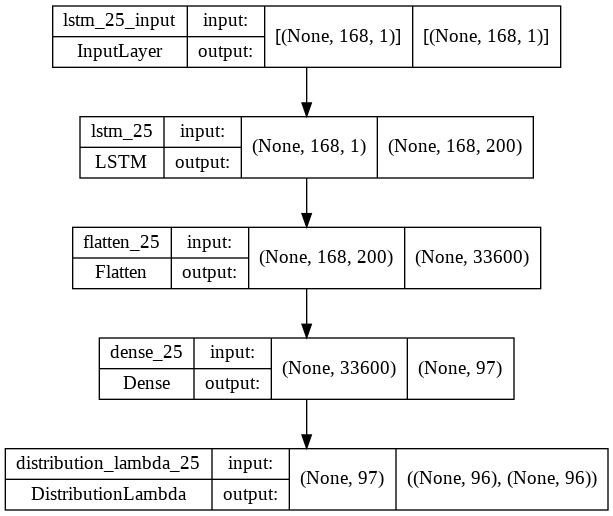

In [ ]:
plot_model(model, to_file='drive/My Drive/MONTA/Plots/Model_LSTM_distLambda.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 168, 200)          161600    
                                                                 
 flatten_25 (Flatten)        (None, 33600)             0         
                                                                 
 dense_25 (Dense)            (None, 97)                3259297   
                                                                 
 distribution_lambda_25 (Dis  ((None, 96),             0         
 tributionLambda)             (None, 96))                        
                                                                 
Total params: 3,420,897
Trainable params: 3,420,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
preds

[]

## Sandbox

In [ ]:
in_seq

array([[29.36],
       [29.4 ],
       [28.91],
       ...,
       [30.05],
       [29.83],
       [29.5 ]])

In [ ]:
x_input.size

168

In [ ]:
out_seq.size # Number of sequences in each fold

10

In [ ]:
out_seq[0].size # Check size of each array

1

In [ ]:
X   # Number of aarrays depends on number of features
# Array format allows to have other input features (exog)

array([[[29.36],
        [29.4 ],
        [28.91],
        ...,
        [30.83],
        [30.95],
        [30.55]],

       [[29.4 ],
        [28.91],
        [28.11],
        ...,
        [30.95],
        [30.55],
        [29.89]],

       [[28.91],
        [28.11],
        [28.24],
        ...,
        [30.55],
        [29.89],
        [29.56]],

       ...,

       [[30.74],
        [30.18],
        [29.71],
        ...,
        [31.04],
        [30.56],
        [29.91]],

       [[30.18],
        [29.71],
        [29.25],
        ...,
        [30.56],
        [29.91],
        [29.72]],

       [[29.71],
        [29.25],
        [28.88],
        ...,
        [29.91],
        [29.72],
        [29.39]]])

In [ ]:
X[0].size

168

In [ ]:
y

array([[30.55, 29.89, 29.56, ..., 29.88, 29.5 , 29.43],
       [29.89, 29.56, 29.11, ..., 29.5 , 29.43, 29.21],
       [29.56, 29.11, 28.99, ..., 29.43, 29.21, 28.83],
       ...,
       [29.91, 29.72, 29.39, ..., 31.38, 30.66, 30.05],
       [29.72, 29.39, 29.52, ..., 30.66, 30.05, 29.83],
       [29.39, 29.52, 29.42, ..., 30.05, 29.83, 29.5 ]])

In [ ]:
y[0].size

96

In [ ]:
n_features

168

In [ ]:
n_features=X.shape[2]

In [ ]:
n_features

1

In [ ]:
np.savetxt("drive/My Drive/MONTA/dists_DistLambda_1.csv", 
           dists,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
############ Save loc and scale of each point for each fold

dist_lambda_1={}
for ii in range(folds):
    dist_lambda_1[f'period_{ii}_mean']=dists[ii].mean()
    dist_lambda_1[f'period_{ii}_stddev']=dists[ii].stddev()

import csv

with open('drive/My Drive/MONTA/dists_lambda1.csv', 'w') as f:  
    for key in dist_lambda_1.keys():
        f.write("%s, %s\n" % (key, dist_lambda_1[key]))

In [ ]:
dists[1].mean()

<tf.Tensor: shape=(1, 96), dtype=float32, numpy=
array([[0.12858364, 0.12858364, 0.12858364, 0.12858364, 0.12858364,
        0.12858364, 0.12858364, 0.12858364, 0.12858364, 0.12858364,
        0.12858364, 0.12858364, 0.12858364, 0.12858364, 0.12858364,
        0.12858364, 0.12858364, 0.12858364, 0.12858364, 0.12858364,
        0.12858364, 0.12858364, 0.12858364, 0.12858364, 0.12858364,
        0.12858364, 0.12858364, 0.12858364, 0.12858364, 0.12858364,
        0.12858364, 0.12858364, 0.12858364, 0.12858364, 0.12858364,
        0.12858364, 0.12858364, 0.12858364, 0.12858364, 0.12858364,
        0.12858364, 0.12858364, 0.12858364, 0.12858364, 0.12858364,
        0.12858364, 0.12858364, 0.12858364, 0.12858364, 0.12858364,
        0.12858364, 0.12858364, 0.12858364, 0.12858364, 0.12858364,
        0.12858364, 0.12858364, 0.12858364, 0.12858364, 0.12858364,
        0.12858364, 0.12858364, 0.12858364, 0.12858364, 0.12858364,
        0.12858364, 0.12858364, 0.12858364, 0.12858364, 0.12858364,

In [ ]:
dists[1].mean()

<tf.Tensor: shape=(1, 96), dtype=float32, numpy=
array([[0.10995037, 0.10995037, 0.10995037, 0.10995037, 0.10995037,
        0.10995037, 0.10995037, 0.10995037, 0.10995037, 0.10995037,
        0.10995037, 0.10995037, 0.10995037, 0.10995037, 0.10995037,
        0.10995037, 0.10995037, 0.10995037, 0.10995037, 0.10995037,
        0.10995037, 0.10995037, 0.10995037, 0.10995037, 0.10995037,
        0.10995037, 0.10995037, 0.10995037, 0.10995037, 0.10995037,
        0.10995037, 0.10995037, 0.10995037, 0.10995037, 0.10995037,
        0.10995037, 0.10995037, 0.10995037, 0.10995037, 0.10995037,
        0.10995037, 0.10995037, 0.10995037, 0.10995037, 0.10995037,
        0.10995037, 0.10995037, 0.10995037, 0.10995037, 0.10995037,
        0.10995037, 0.10995037, 0.10995037, 0.10995037, 0.10995037,
        0.10995037, 0.10995037, 0.10995037, 0.10995037, 0.10995037,
        0.10995037, 0.10995037, 0.10995037, 0.10995037, 0.10995037,
        0.10995037, 0.10995037, 0.10995037, 0.10995037, 0.10995037,

In [ ]:
# dists[1].stddev()[0].__numpy__() ###### Trying to get the distribution inferred. Can also get 1000 samples and get the means, though it´s not gonna be the real one (Law of large numbers)

In [ ]:
dist_lambda_1.keys() ####### Check if saved correctly

dict_keys(['fold_0_mean', 'fold_0_stddev', 'fold_1_mean', 'fold_1_stddev', 'fold_2_mean', 'fold_2_stddev', 'fold_3_mean', 'fold_3_stddev', 'fold_4_mean', 'fold_4_stddev', 'fold_5_mean', 'fold_5_stddev', 'fold_6_mean', 'fold_6_stddev', 'fold_7_mean', 'fold_7_stddev', 'fold_8_mean', 'fold_8_stddev', 'fold_9_mean', 'fold_9_stddev', 'fold_10_mean', 'fold_10_stddev', 'fold_11_mean', 'fold_11_stddev', 'fold_12_mean', 'fold_12_stddev', 'fold_13_mean', 'fold_13_stddev', 'fold_14_mean', 'fold_14_stddev', 'fold_15_mean', 'fold_15_stddev', 'fold_16_mean', 'fold_16_stddev', 'fold_17_mean', 'fold_17_stddev', 'fold_18_mean', 'fold_18_stddev', 'fold_19_mean', 'fold_19_stddev'])

In [ ]:
tensor_draw = dists[0].sample(1000) # Sample a 1000 values since we want a better number to get better results (Law of large numbers. Then we´ll squeexe it to the 96 values we want.)
pd.DataFrame(tensor_draw.numpy().squeeze())

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.130997,0.141072,0.101897,0.087041,0.077727,0.142586,0.066832,0.129811,0.124115,0.108239,...,0.095275,0.160877,0.142468,0.111729,0.104284,0.108921,0.151233,0.146287,0.154684,0.104105
1,0.151163,0.151928,0.134710,0.075283,0.135166,0.169992,0.097627,0.144542,0.147046,0.099599,...,0.121193,0.087647,0.104612,0.086844,0.116119,0.150943,0.140878,0.120105,0.089824,0.141739
2,0.139449,0.070873,0.155438,0.141010,0.168799,0.160140,0.184464,0.125017,0.074180,0.089305,...,0.122234,0.138980,0.159500,0.170527,0.141387,0.120413,0.157809,0.120962,0.147071,0.078248
3,0.146080,0.127012,0.118005,0.152005,0.180345,0.115962,0.168513,0.119853,0.123504,0.131268,...,0.145303,0.131967,0.099966,0.091607,0.170478,0.135675,0.106967,0.160573,0.185974,0.160303
4,0.078682,0.182750,0.118401,0.111520,0.138303,0.103653,0.127164,0.075424,0.104639,0.160949,...,0.160262,0.150744,0.143632,0.087572,0.162915,0.128505,0.144165,0.139184,0.129817,0.166087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.165888,0.196745,0.170995,0.140169,0.120626,0.100792,0.130735,0.150754,0.139736,0.160361,...,0.177437,0.088675,0.108217,0.086263,0.153475,0.098749,0.119532,0.154505,0.159664,0.187901
996,0.081008,0.111318,0.099808,0.189210,0.124599,0.136535,0.135512,0.102470,0.128791,0.078593,...,0.143195,0.068469,0.138437,0.112720,0.143986,0.127558,0.144649,0.130748,0.125602,0.150809
997,0.145823,0.126604,0.162844,0.145805,0.123631,0.119705,0.104722,0.124408,0.137401,0.088173,...,0.133743,0.120121,0.093222,0.125822,0.110459,0.089087,0.119165,0.166879,0.095864,0.149682
998,0.121637,0.141614,0.097076,0.131654,0.127812,0.146930,0.145640,0.115445,0.148252,0.120861,...,0.142117,0.152744,0.139989,0.124432,0.155388,0.115230,0.160979,0.162330,0.130722,0.130833


Defined the following quantiles:

*   q40 as 0.40
*   q60 as 0.60

Use [Normal distribution picture ](https://en.wikipedia.org/wiki/Normal_distribution#/media/File:Standard_deviation_diagram_micro.svg)
 to talk about selection of model, why DistLmabda normal, etc.






In [ ]:
df_samples_scaled = pd.DataFrame(tensor_draw.numpy().squeeze())
tensor_draw = dists[0].sample(1000) # Sample a 1000 values since we want a better number to get better results (Law of large numbers. Then we´ll squeexe it to the 96 values we want.)
df_samples_scaled=pd.DataFrame(tensor_draw.numpy().squeeze())
m=df_samples_scaled.mean(axis=0)
s=df_samples_scaled.std(axis=0)
q40=df_samples_scaled.quantile(q=.40,axis=0)
q60=df_samples_scaled.quantile(q=.60,axis=0)
distrib = {'mean':m, 'stddev':s, 'percentile_40':q40, 'percentile_60':q60}
df_distr=pd.DataFrame(distrib)
df_distr.head()

,mean,stddev,quantile_05,quantile_25,quantile_75,quantile_95
0,0.128465,0.028931,0.080859,0.108973,0.147993,0.176915
1,0.128910,0.029235,0.081711,0.108093,0.149674,0.175105
2,0.128734,0.028344,0.082884,0.109451,0.148154,0.175621
3,0.126381,0.028672,0.077187,0.107413,0.146437,0.173501
4,0.128149,0.029240,0.082142,0.107808,0.147311,0.176461


In [ ]:
for ii in range(period):
    tensor_draw = dists[ii].sample(1000) # Sample a 1000 values since we want a better number to get better results (Law of large numbers. Then we´ll squeexe it to the 96 values we want.)
    df_samples_scaled=pd.DataFrame(tensor_draw.numpy().squeeze())
    m=df_samples_scaled.mean(axis=0)
    s=df_samples_scaled.std(axis=0)
    q05=df_samples_scaled.quantile(q=.05,axis=0)
    q25=df_samples_scaled.quantile(q=.25,axis=0)
    q40=df_samples_scaled.quantile(q=.40,axis=0)
    q60=df_samples_scaled.quantile(q=.60,axis=0)
    q75=df_samples_scaled.quantile(q=.75,axis=0)
    q95=df_samples_scaled.quantile(q=.95,axis=0)
    distrib = {'mean':m, 'stddev':s, 'quantile_05':q05, 'quantile_25':q25, 'quantile_75':q75, 'quantile_95':q95,}
    df_distr=pd.DataFrame(distrib)
    df_distr.to_csv(f'drive/My Drive/MONTA/data_lambda1_fold{ii}.csv')

### Loading past preds

In [ ]:
dist_lambda_preds_scaled=pd.read_csv('drive/My Drive/MONTA/Plots/DistLambda_LSTM/Predictions/data_lambda1_fold3.csv')
dist_lambda_preds_scaled.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
dist_lambda_preds_scaled.tail()

,mean,stddev,quantile_05,quantile_25,quantile_75,quantile_95
91,0.138708,0.489421,-0.689420,-0.173927,0.454177,0.962379
92,0.143540,0.507518,-0.718275,-0.191239,0.467419,1.010570
93,0.112627,0.481079,-0.662474,-0.202898,0.434245,0.899245
94,0.146559,0.490662,-0.694967,-0.192866,0.477258,0.938211
95,0.128365,0.485149,-0.673848,-0.189441,0.436596,0.896057


In [ ]:
# dist_lambda_preds_scaled.drop('Unnamed: 0', axis=1, inplace=True)  ####### Should've done the denormalization before getting the mean, quantiles etc. When sampled, denormalize and get these values.
ii = 3
denormed = lambda x: (x *(p_max - p_min) + p_min) 
for col in dist_lambda_preds_scaled.columns:
  dist_lambda_preds[col] = dist_lambda_preds_scaled[col].apply(denormed)
dist_lambda_preds = dist_lambda_preds.iloc[:-1]
print(dist_lambda_preds.shape)
dist_lambda_preds.tail()

(96, 6)


,mean,stddev,quantile_05,quantile_25,quantile_75,quantile_95
91,33.883282,123.928906,-178.738488,-46.385773,114.879885,245.360887
92,35.124000,128.575144,-186.147163,-50.830726,118.279954,257.733779
93,27.187009,121.787008,-171.820243,-53.824003,109.762478,229.151194
94,35.898923,124.247443,-180.162754,-51.248370,120.805968,239.155650
95,31.227763,122.832108,-174.740570,-50.369044,110.366048,228.332639


In [ ]:
indexes # Check

[[1968, 2064],
 [4032, 4128],
 [6096, 6192],
 [8160, 8256],
 [10224, 10320],
 [12288, 12384],
 [14352, 14448],
 [16416, 16512],
 [18480, 18576],
 [20544, 20640],
 [22608, 22704],
 [24672, 24768],
 [26736, 26832],
 [28800, 28896],
 [30864, 30960],
 [32928, 33024],
 [34992, 35088],
 [37056, 37152],
 [39120, 39216],
 [41184, 41280]]

### $Z-Score$

Because the Q1 and Q3 ranges are too wide, we calculate the 40th and 60th percentiles of the prediction distributions to use as ranges.


$Q_{percentile}$ = μ + $Z_{score}$ * σ 

$Z_{score_{40th}}$ =-0.25

$Z_{score_{60th}}$ =0.25
 

In [ ]:
zscore40 =-.25
zscore60 =.25
dist_lambda_preds["sigma_plus"] = dist_lambda_preds["mean"] + dist_lambda_preds["stddev"]
dist_lambda_preds["sigma_minus"] = dist_lambda_preds["mean"] - dist_lambda_preds["stddev"]
dist_lambda_preds["quantile_40"] = dist_lambda_preds["mean"] + zscore40 * dist_lambda_preds["stddev"]
dist_lambda_preds["quantile_60"] = dist_lambda_preds["mean"] + zscore60 * dist_lambda_preds["stddev"]

Text(0.5, 1.0, 'Forecast from 2017-12-08 00:00:00 to 2017-12-11 23:00:00')

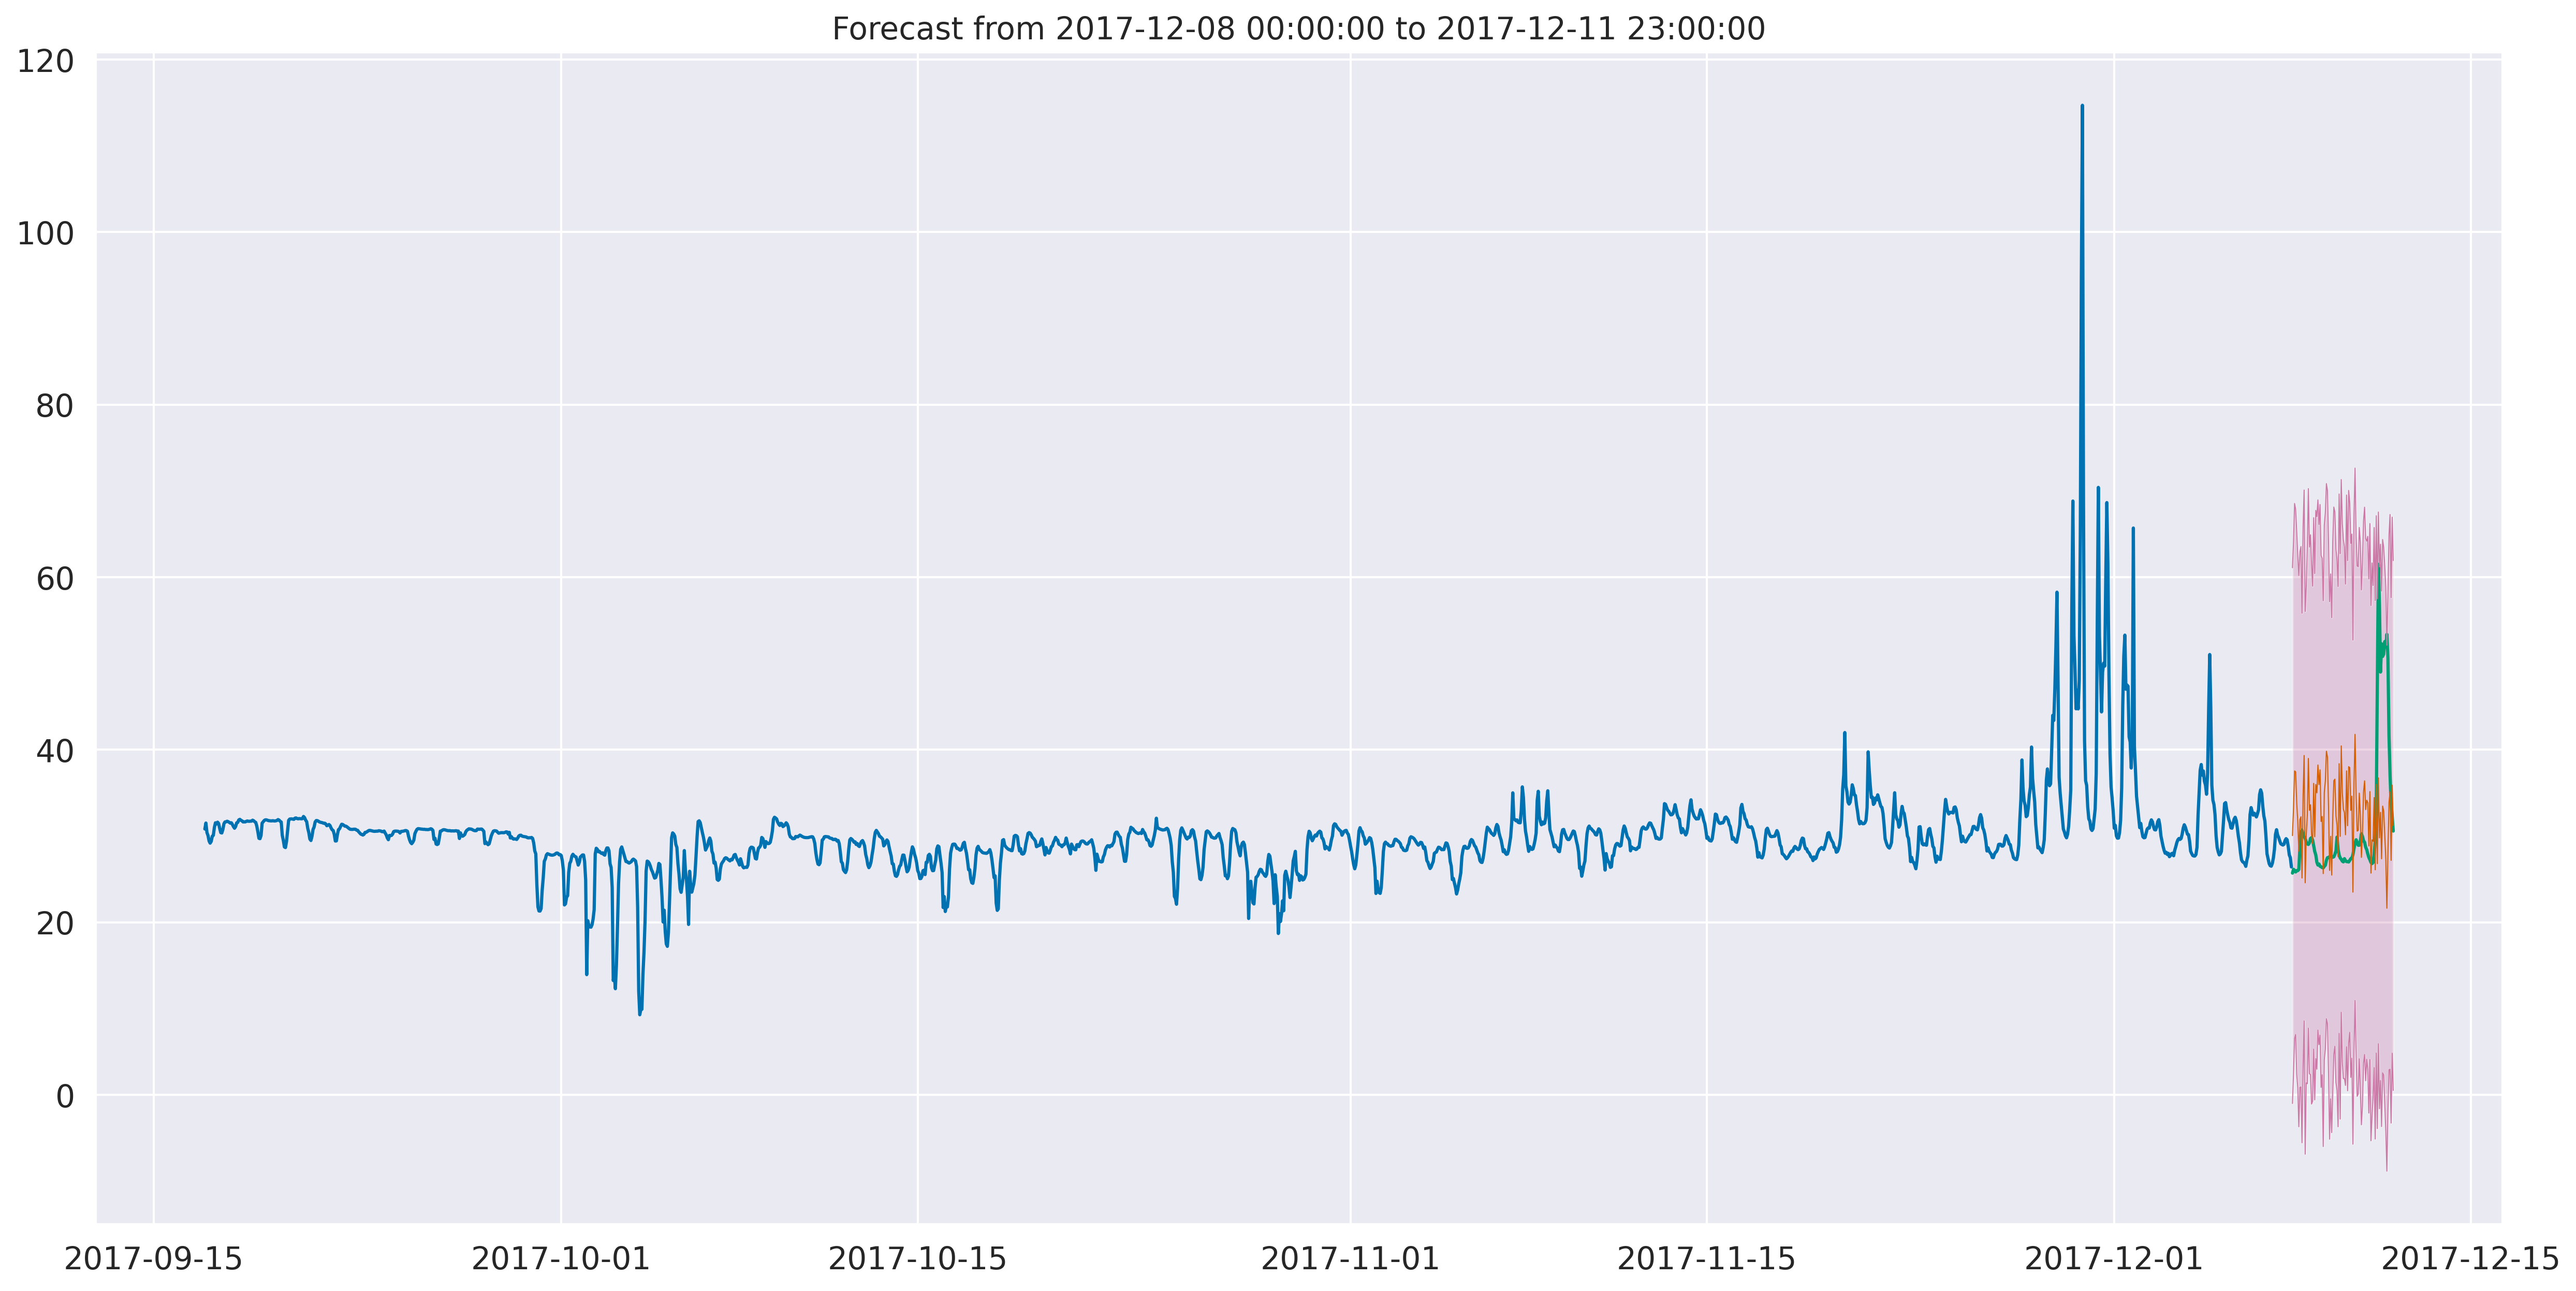

In [ ]:
plt.rcParams.update(params)
ii=3      
fig=plt.figure(figsize=[20, 10])
# plt.plot(in_seq.T, y_true.T, 'b.', label='observed');
plt.plot(data[(indexes[ii][0]-train_size):indexes[ii][0]], label = "True price train")
plt.plot(data[indexes[ii][0]:indexes[ii][1]], label = "True price test")
plt.plot(data[indexes[ii][0]:indexes[ii][1]].index, dist_lambda_preds['mean'], linewidth=.5, label='predicted mean')
plt.plot(data[indexes[ii][0]:indexes[ii][1]].index, dist_lambda_preds['quantile_40'], 'C3', linewidth=.5, label='predicted 40th percentile')
plt.plot(data[indexes[ii][0]:indexes[ii][1]].index, dist_lambda_preds['quantile_60'], 'C3', linewidth=.5, label='predicted 60th percentile')
plt.fill_between(data[indexes[ii][0]:indexes[ii][1]].index, dist_lambda_preds['quantile_40'], dist_lambda_preds['quantile_60'], facecolor='C3', alpha=.3)
plt.title(f'Forecast from {data[indexes[ii][0]:indexes[ii][1]].index[0]} to {data[indexes[ii][0]:indexes[ii][1]].index[-1]}')

fig.savefig(f'drive/My Drive/MONTA/Plots/Pred distlambda_lstm Fold 3.jpg')

# <font : color="red"> Take care of this first thing! </font>

Understand why soft relu!!! [check this](https://www.tensorflow.org/api_docs/python/tf/math/softplus)

A nice visualization can be to plot all distribution, a timelapse of them...?

# Evaluation

## Predictions extraction 20-periods

In [ ]:
plt.rcParams.update(params)

df_distr=pd.DataFrame()
period_preds={}


for ii in range(periods):
  ##### Sampling and getting attributes
  tensor_draw = dists[ii].sample(1000) # Sample a 1000 values since we want a better number to get better results (Law of large numbers)
  df_samples_scaled=pd.DataFrame(tensor_draw.numpy().squeeze())
  m=df_samples_scaled.mean(axis=0)
  s=df_samples_scaled.std(axis=0)
  q40=df_samples_scaled.quantile(q=.40,axis=0)
  q60=df_samples_scaled.quantile(q=.60,axis=0)
  distrib = {'mean':m, 'stddev':s, 'percentile_40':q40, 'percentile_60':q60}
  df_distr_scaled=pd.DataFrame(distrib)
  ##### De-normalization
  denormed = lambda x: (x *(p_max - p_min) + p_min) 
  df_distr=df_distr_scaled.copy()
  for col in df_distr_scaled.columns:
    df_distr[col] = df_distr[col].apply(denormed)
  # print(df_distr.tail()) ### Check transformations

  ###### Saving results for RMSE...
  period_preds[f'period_{ii}']=df_distr['mean']
  print(period_preds[f'period_{ii}']) ### Check if saved appropiately

  ####### Plotting

  # ii=3    ##### Used for debugging
  fig=plt.figure(figsize=[20, 10])
  # plt.plot(in_seq.T, y_true.T, 'b.', label='observed');
  plt.plot(data[(indexes[ii][0]-train_size):indexes[ii][0]], label = "True price train")
  plt.plot(data[indexes[ii][0]:indexes[ii][1]], label = "True price test")
  plt.plot(data[indexes[ii][0]:indexes[ii][1]].index, df_distr['mean'], linewidth=.5, label='predicted mean')
  plt.plot(data[indexes[ii][0]:indexes[ii][1]].index, df_distr['percentile_40'], 'C3', linewidth=.5, label='predicted 40th-60th percentile')
  plt.plot(data[indexes[ii][0]:indexes[ii][1]].index, df_distr['percentile_60'], 'C3', linewidth=.5)
  plt.fill_between(data[indexes[ii][0]:indexes[ii][1]].index, df_distr['percentile_40'], df_distr['percentile_60'], facecolor='C3', alpha=.3)
  plt.title(f'Forecast from {data[indexes[ii][0]:indexes[ii][1]].index[0]} to {data[indexes[ii][0]:indexes[ii][1]].index[-1]}')
  plt.legend()
  fig.savefig(f'drive/My Drive/MONTA/Plots/Pred distlambda_lstm Period {ii}.jpg')
  plt.show()
  # if ii== 3: break   #### Used for debugging

Output hidden; open in https://colab.research.google.com to view.

## RMSE

In [ ]:
###### De-normalized RMSE ######
rmse = []
rmse = [(np.sqrt(mean_squared_error(
    data[indexes[ii][0]:indexes[ii][1]], period_preds[f'period_{ii}'])))
                 for ii in range(folds)]
rmse[0] # Check that it is not in the 0.01 range

11.185181033828018

Period 1 has  a MAPE of 38.24 % and an RMSE of 11.1852
Period 2 has  a MAPE of 335.93 % and an RMSE of 83.2402
Period 3 has  a MAPE of 33.49 % and an RMSE of 9.6626
Period 4 has  a MAPE of 59.26 % and an RMSE of 20.7802
Period 5 has  a MAPE of 40.66 % and an RMSE of 22.673
Period 6 has  a MAPE of 11.97 % and an RMSE of 5.8911
Period 7 has  a MAPE of 7.78 % and an RMSE of 4.0867
Period 8 has  a MAPE of 8.85 % and an RMSE of 5.6131
Period 9 has  a MAPE of 10.47 % and an RMSE of 5.78
Period 10 has  a MAPE of 385.74 % and an RMSE of 165.9556
Period 11 has  a MAPE of 7.03 % and an RMSE of 3.2023
Period 12 has  a MAPE of 39.82 % and an RMSE of 16.1054
Period 13 has  a MAPE of 13.72 % and an RMSE of 3.4179
Period 14 has  a MAPE of 1144.88 % and an RMSE of 54.7198
Period 15 has  a MAPE of 100.99 % and an RMSE of 1.961
Period 16 has  a MAPE of 47.91 % and an RMSE of 3.9894
Period 17 has  a MAPE of 37.09 % and an RMSE of 10.3469
Period 18 has  a MAPE of 4.67 % and an RMSE of 1.9792
Period 19 has

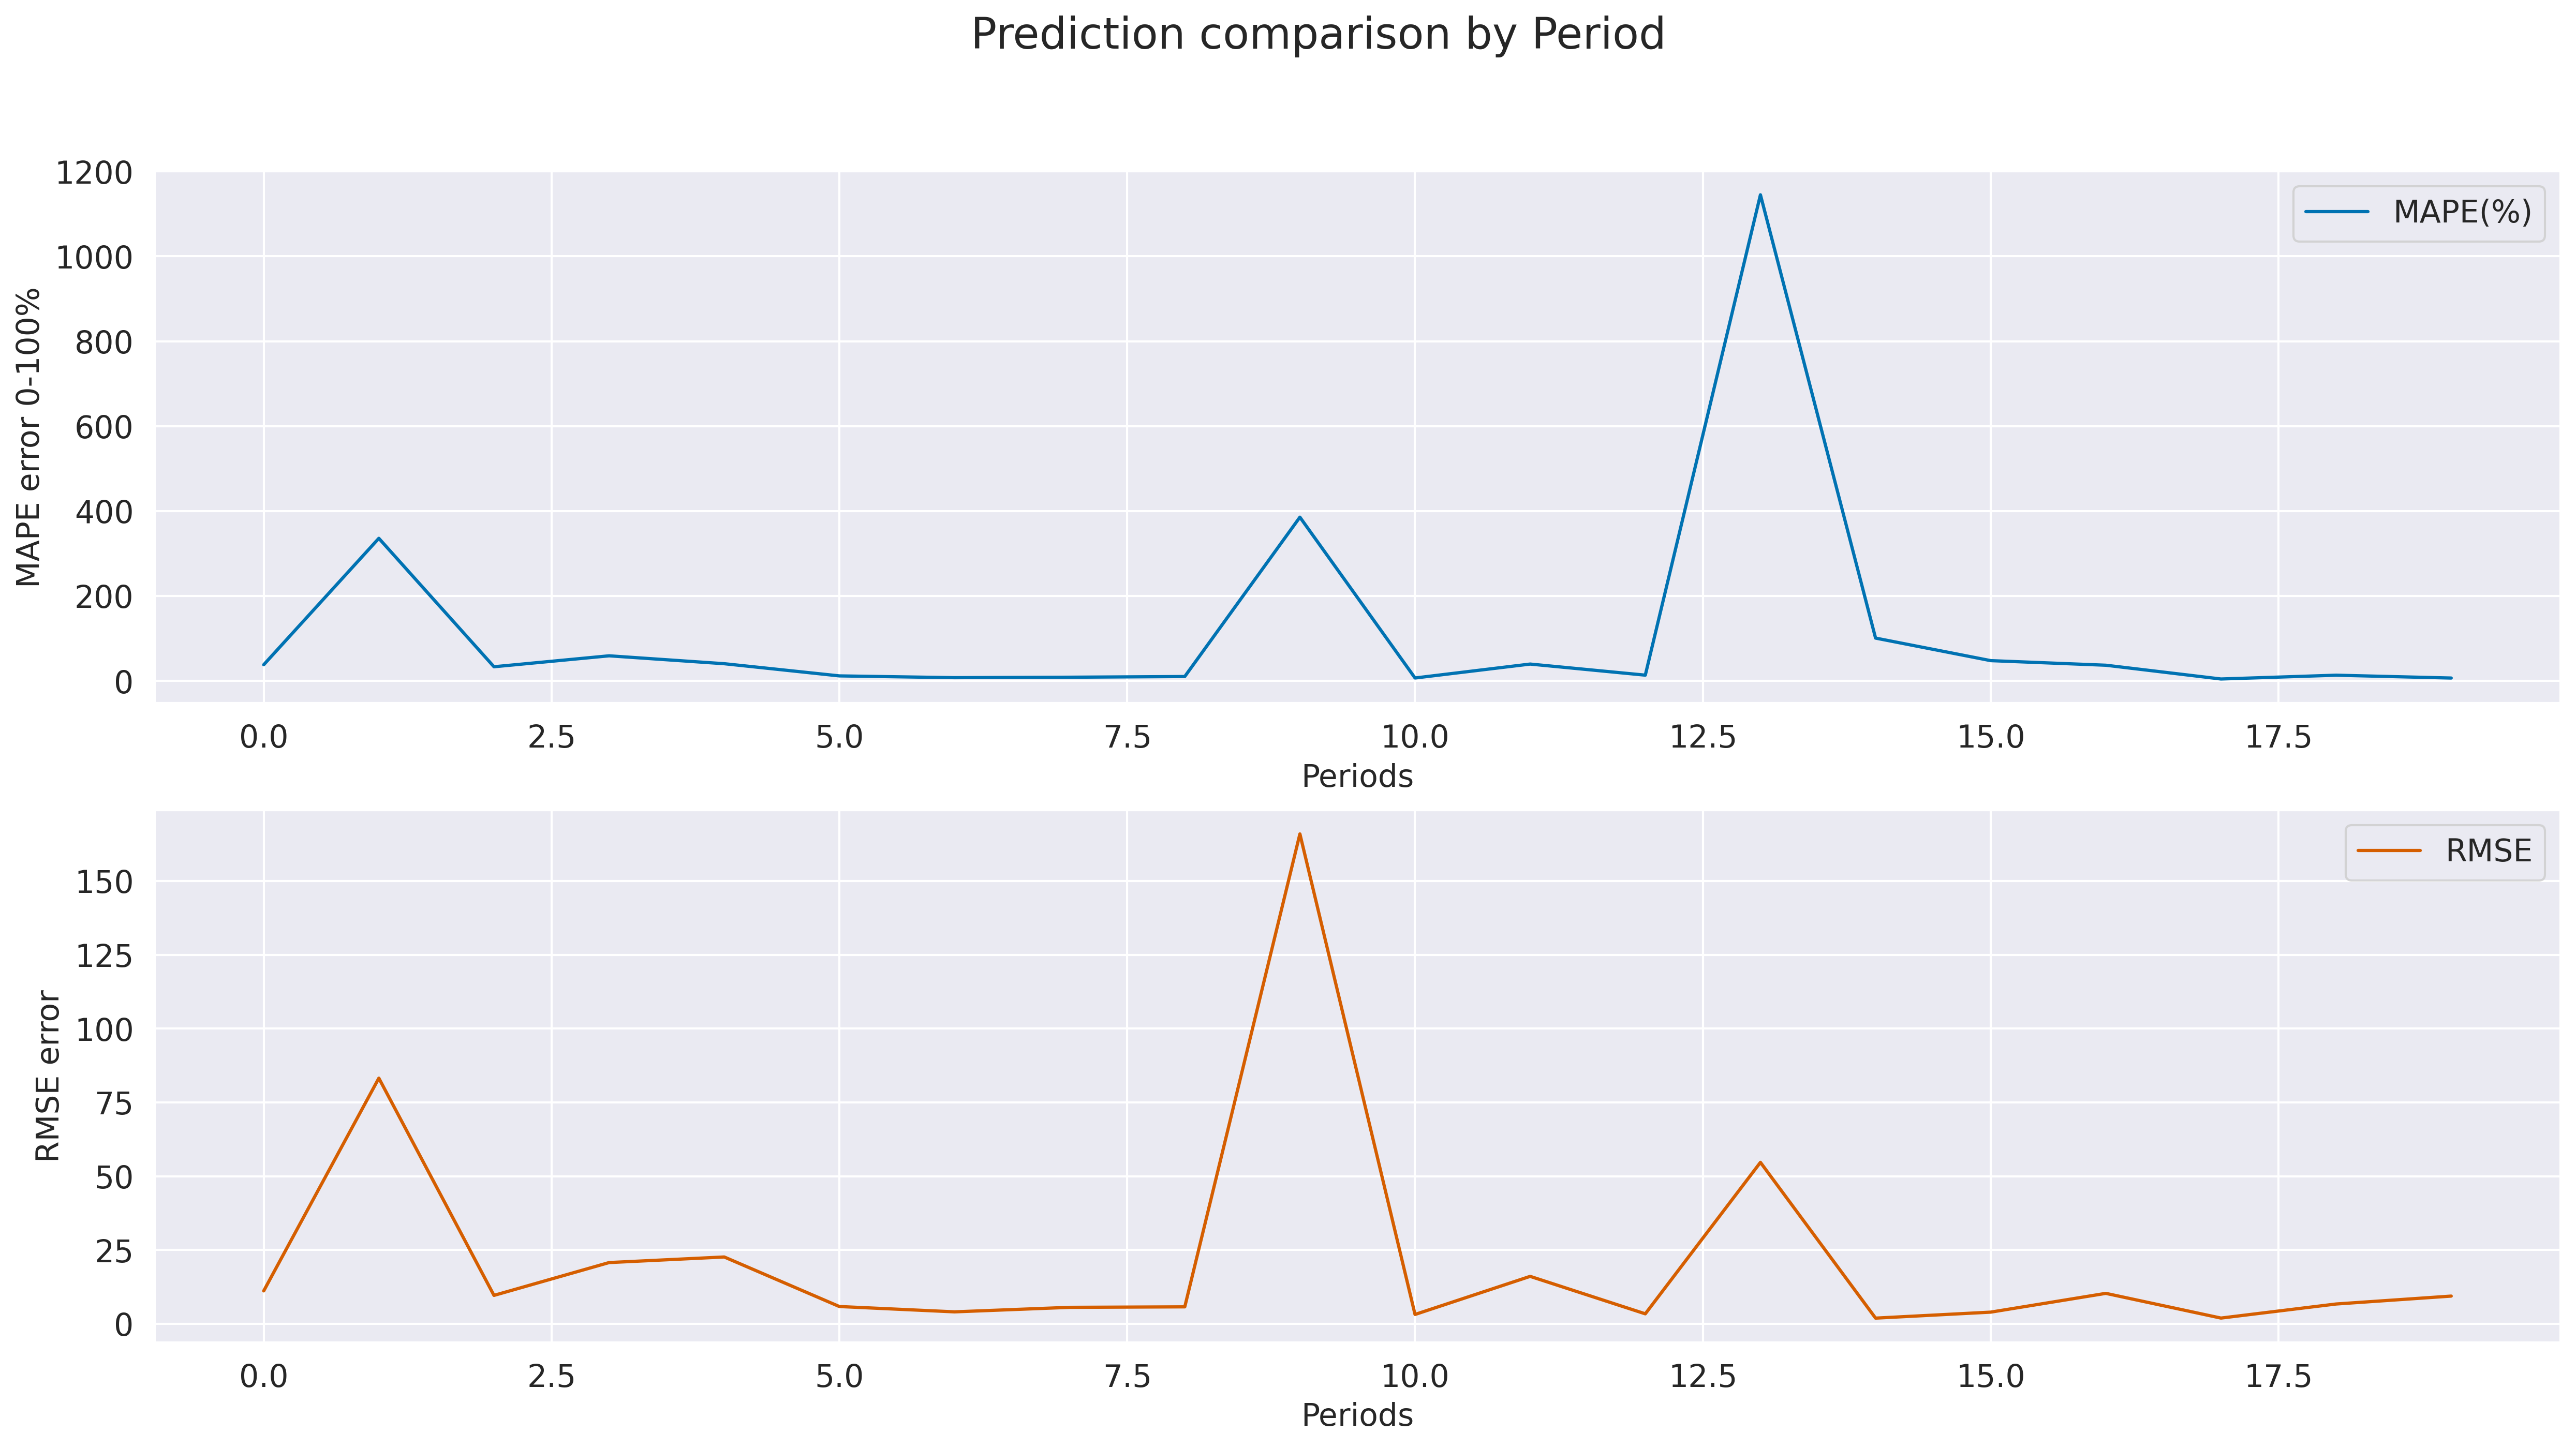

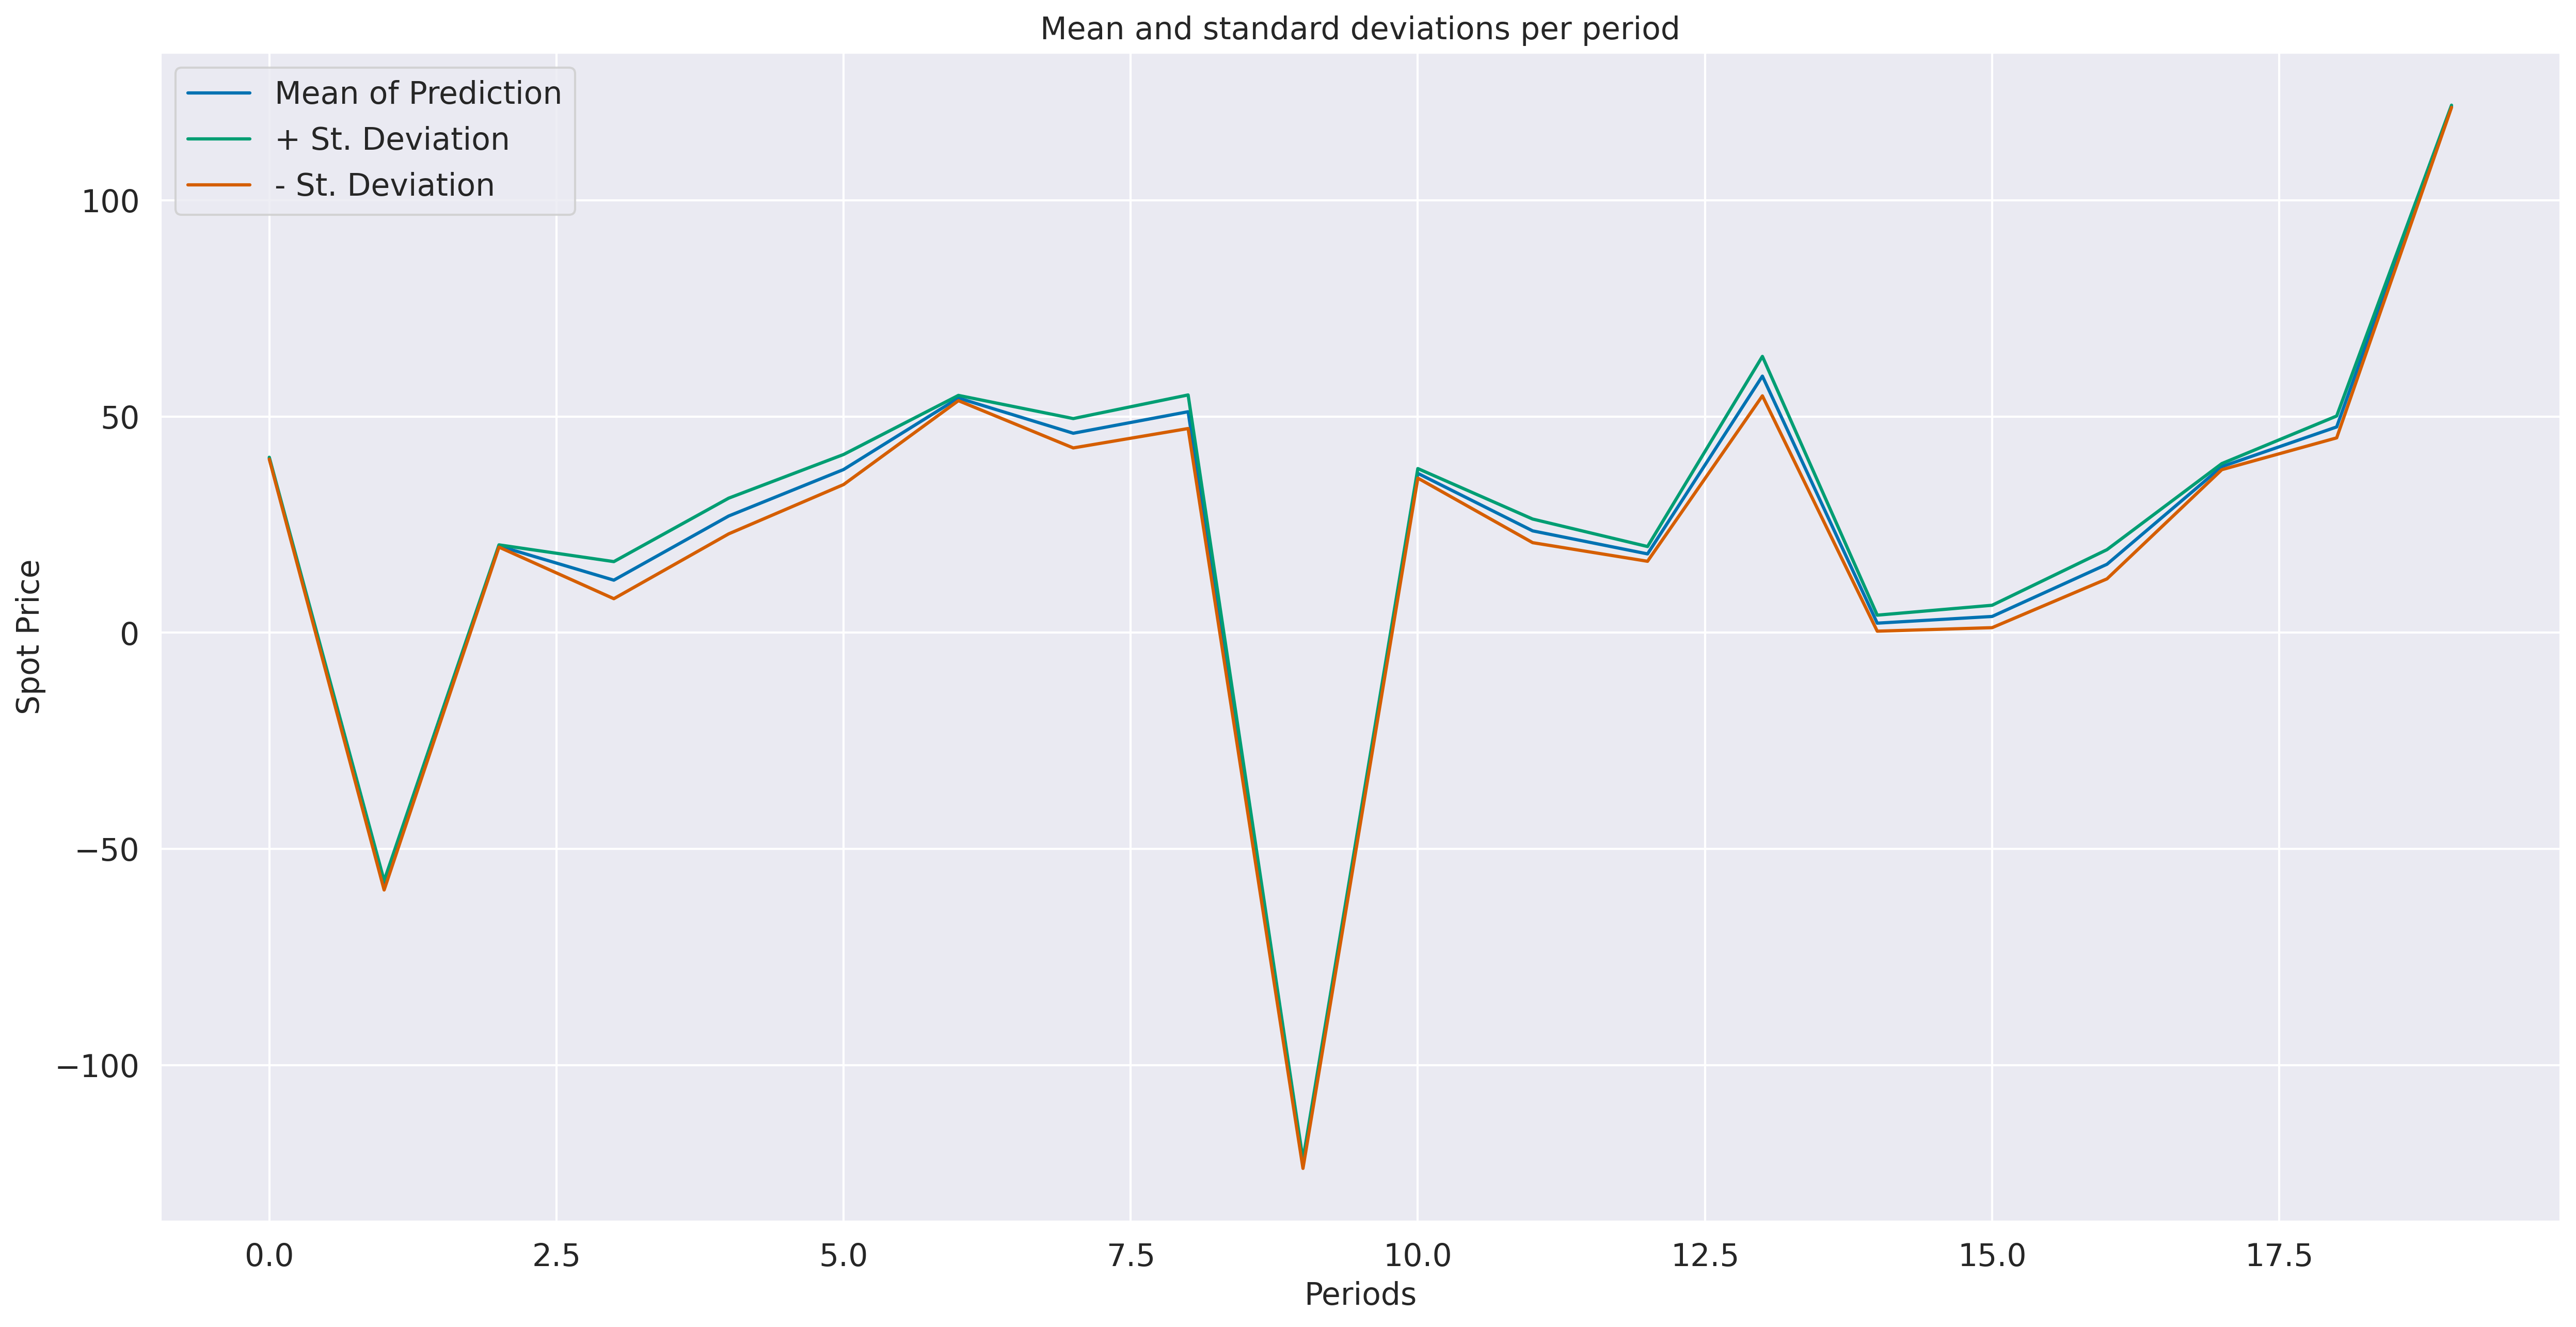

In [ ]:
mape =[]
means = []
stdup = []
stddown = []
for ii in range(periods):
    val = calculate_mape(data[indexes[ii][0]:indexes[ii][1]], period_preds[f'period_{ii}'])
    mape.append(val)
    means.append(np.mean(period_preds[f'period_{ii}']))
    stdup.append(np.mean(period_preds[f'period_{ii}']) + np.std(period_preds[f'period_{ii}']))
    stddown.append(np.mean(period_preds[f'period_{ii}']) - np.std(period_preds[f'period_{ii}']))
    print(f'Period {ii+1} has  a MAPE of {val} % and an RMSE of {round(rmse[ii], 4)}')
print(f' Average MAPE: {np.mean(mape)}')
print(f' Average RMSE: {np.mean(rmse)}')

plt.rcParams.update(params)

###### Error Plots ######    
fig, (ax1, ax2) = plt.subplots(2, 1)
plt.suptitle("Prediction comparison by Period", fontsize=20)
ax1.set_xlabel('Periods')
ax1.set_ylabel('MAPE error 0-100%')
#a, = ax1.plot(mape, "C0", label = "MAPE(%)")
ax1.plot(mape, "C0", label = "MAPE(%)")
ax1.legend(loc='best')
ax2.plot(rmse, "C2", label = "RMSE")
ax2.set_ylabel("RMSE error")
ax2.set_xlabel("Periods")
ax2.legend(loc='best')
plt.savefig(f'drive/My Drive/MONTA/Plots/Pred DistLambda_LSTM Errors per Period.jpg')
plt.show()

###### Prediction Plots ######
fig3, ax3 = plt.subplots()   
ax3.set_xlabel('Periods') 
ax3.set_ylabel('Spot Price') 
ax3.plot(means, label = "Mean of Prediction")
ax3.plot((stdup), label = "+ St. Deviation")
ax3.plot((stddown), label = "- St. Deviation")
plt.title("Mean and standard deviations per period")
plt.legend()
plt.savefig(f'drive/My Drive/MONTA/Plots/Pred DistLambda_LSTM Mean and standard deviation.jpg')
plt.show()

## Time-related

In [ ]:
preds_values = [val for key in period_preds.keys()
          for val in period_preds[key]]
# print(preds_values)
preds_idx = [data[idx_rng[0]:idx_rng[1]].index for idx_rng in indexes]
preds_idx = [pd.to_datetime(val) for matrix in preds_idx
          for val in matrix]
# preds_idx

In [ ]:
preds_df = pd.DataFrame(data=preds_values, index = preds_idx)
preds_df.reset_index(inplace = True)
preds_df.columns = ["datetime", "Predicted Price"]
preds_df["hour"] = preds_df["datetime"].dt.hour
preds_df["dayofweek"] = preds_df["datetime"].dt.weekday
#true_test = data.reset_index()
preds_df = preds_df.merge(data, how = "left", on = "datetime")
# Square root of the incremental mean of the difference
preds_df["RMSE"] = np.sqrt(((preds_df["Predicted Price"] - preds_df.price)**2).expanding().mean()) 

In [ ]:
drive_path='drive/My Drive/MONTA/'
folder = "Plots/"
subfolder = "DistLambda_LSTM_3"
filename = "/Preds_DistLambda_LSTM"
filetype = ".csv"
preds_df.to_csv(path_or_buf=drive_path+folder+subfolder+filename+filetype)
preds_df.head() # Data check

,datetime,Predicted Price,hour,dayofweek,price,RMSE
0,2017-03-25 00:00:00,40.185773,0,5,28.93,11.255773
1,2017-03-25 01:00:00,40.100084,1,5,28.82,11.267935
2,2017-03-25 02:00:00,40.021639,2,5,28.34,11.407503
3,2017-03-25 03:00:00,40.676961,3,5,28.17,11.692064
4,2017-03-25 04:00:00,40.483705,4,5,28.03,11.848310


hour
0     44.421248
1     44.455149
2     44.485579
3     44.514796
4     44.539509
5     44.561561
6     44.581370
7     44.600427
8     44.617533
9     44.635754
10    44.653207
11    44.667966
12    44.682375
13    44.697165
14    44.710805
15    44.724528
16    44.737427
17    44.748780
18    44.759431
19    44.768446
20    44.776500
21    44.783532
22    44.789330
23    44.795675
Name: RMSE, dtype: float64

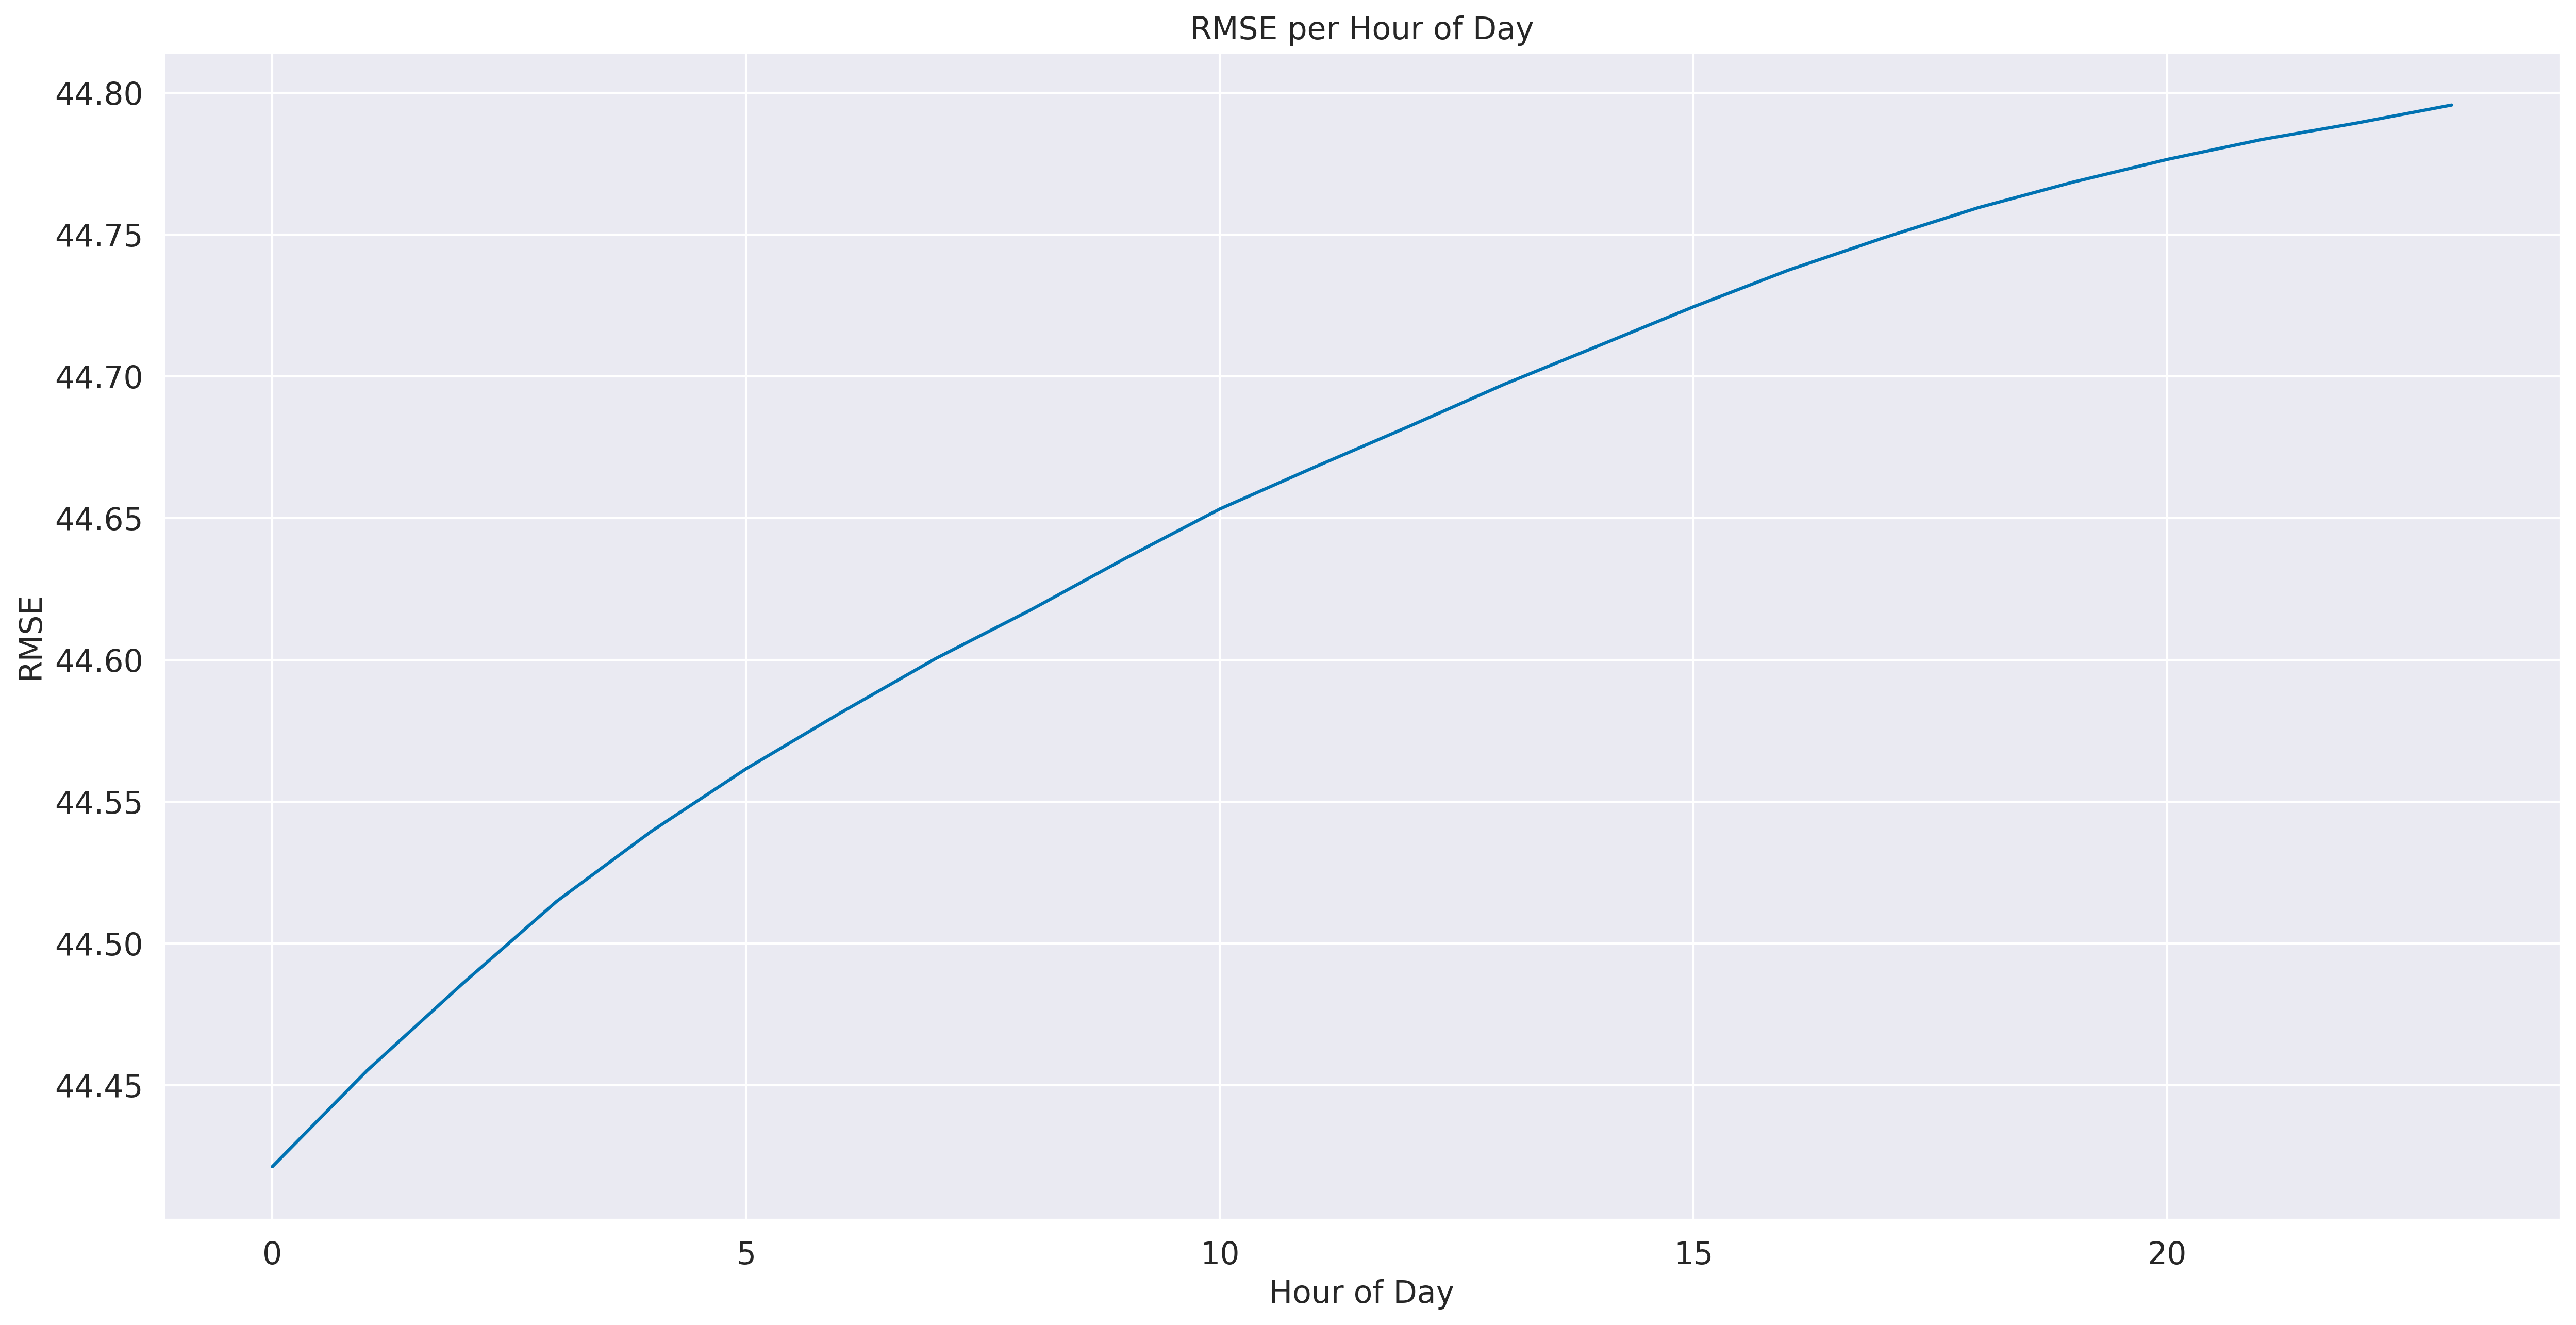

In [ ]:
hour_preds = preds_df.groupby("hour")["RMSE"].mean()
display(hour_preds)
plt.plot(hour_preds,"C0")
plt.xlabel('Hour of Day') 
plt.ylabel('RMSE') 
plt.title("RMSE per Hour of Day")
plt.savefig(f'drive/My Drive/MONTA/Plots/DistLambda_LSTM Hourly error.jpg')
plt.show()

dayofweek
0    41.637941
1    41.926827
2    46.219595
3    46.414834
4    48.190418
5    44.882015
6    43.689820
Name: RMSE, dtype: float64

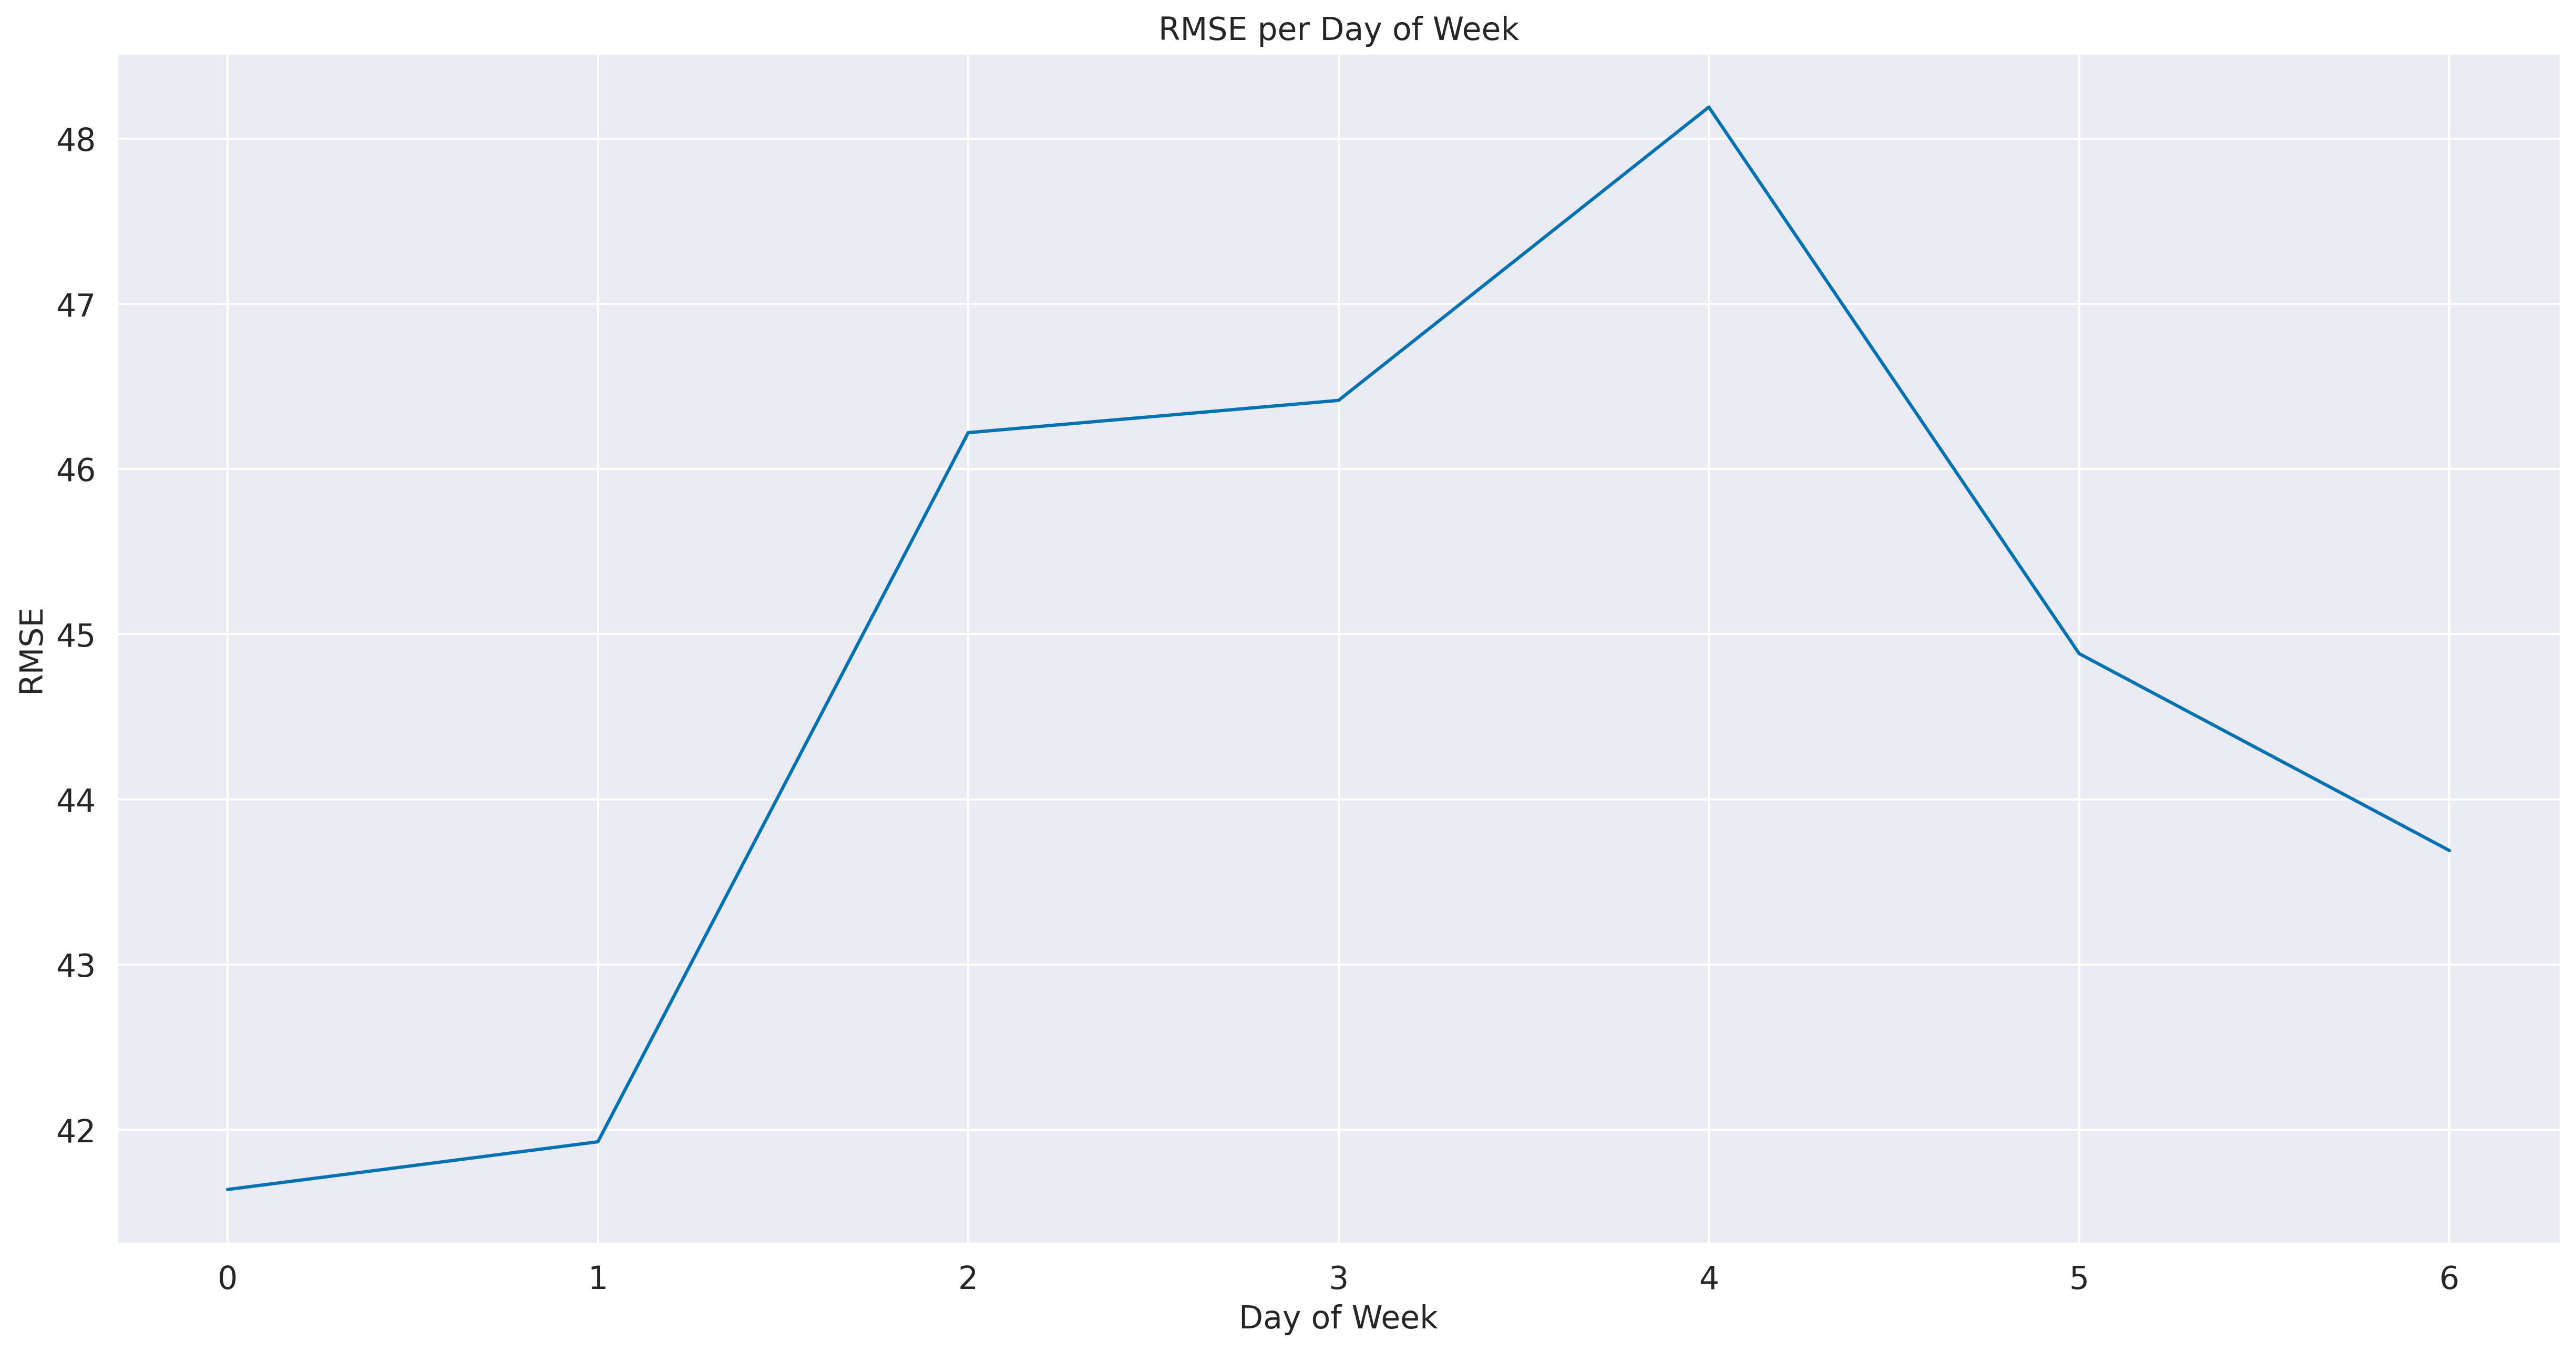

In [ ]:
preds_df["dayofweek"] = preds_df["datetime"].dt.dayofweek
weekday_preds = preds_df.groupby("dayofweek")["RMSE"].mean()
display(weekday_preds)
plt.plot(weekday_preds,"C0")
plt.xlabel('Day of Week') 
plt.ylabel('RMSE') 
plt.title("RMSE per Day of Week")
plt.savefig(f'drive/My Drive/MONTA/Plots/DistLambda_LSTM Day of Week error.jpg')
plt.show()

dayofweek,0,1,2,3,4,5,6
hour,,,,,,,
0,40.618723,41.713905,45.850375,46.150343,48.248333,44.888248,43.940692
1,40.789908,41.739810,45.887150,46.175127,48.243422,44.884699,43.915798
2,40.929960,41.762840,45.921273,46.200973,48.238841,44.892259,43.893149
3,41.050421,41.785469,45.955910,46.225363,48.234279,44.912218,43.871966
4,41.158107,41.808278,45.986875,46.248588,48.227969,44.921032,43.849833
5,41.257183,41.825588,46.020362,46.272531,48.222414,44.920488,43.828862
6,41.340469,41.845926,46.052045,46.296101,48.216986,44.917717,43.809950
7,41.422441,41.864047,46.084384,46.319468,48.212617,44.913352,43.789446
8,41.500420,41.882434,46.118566,46.341614,48.208409,44.899768,43.767085


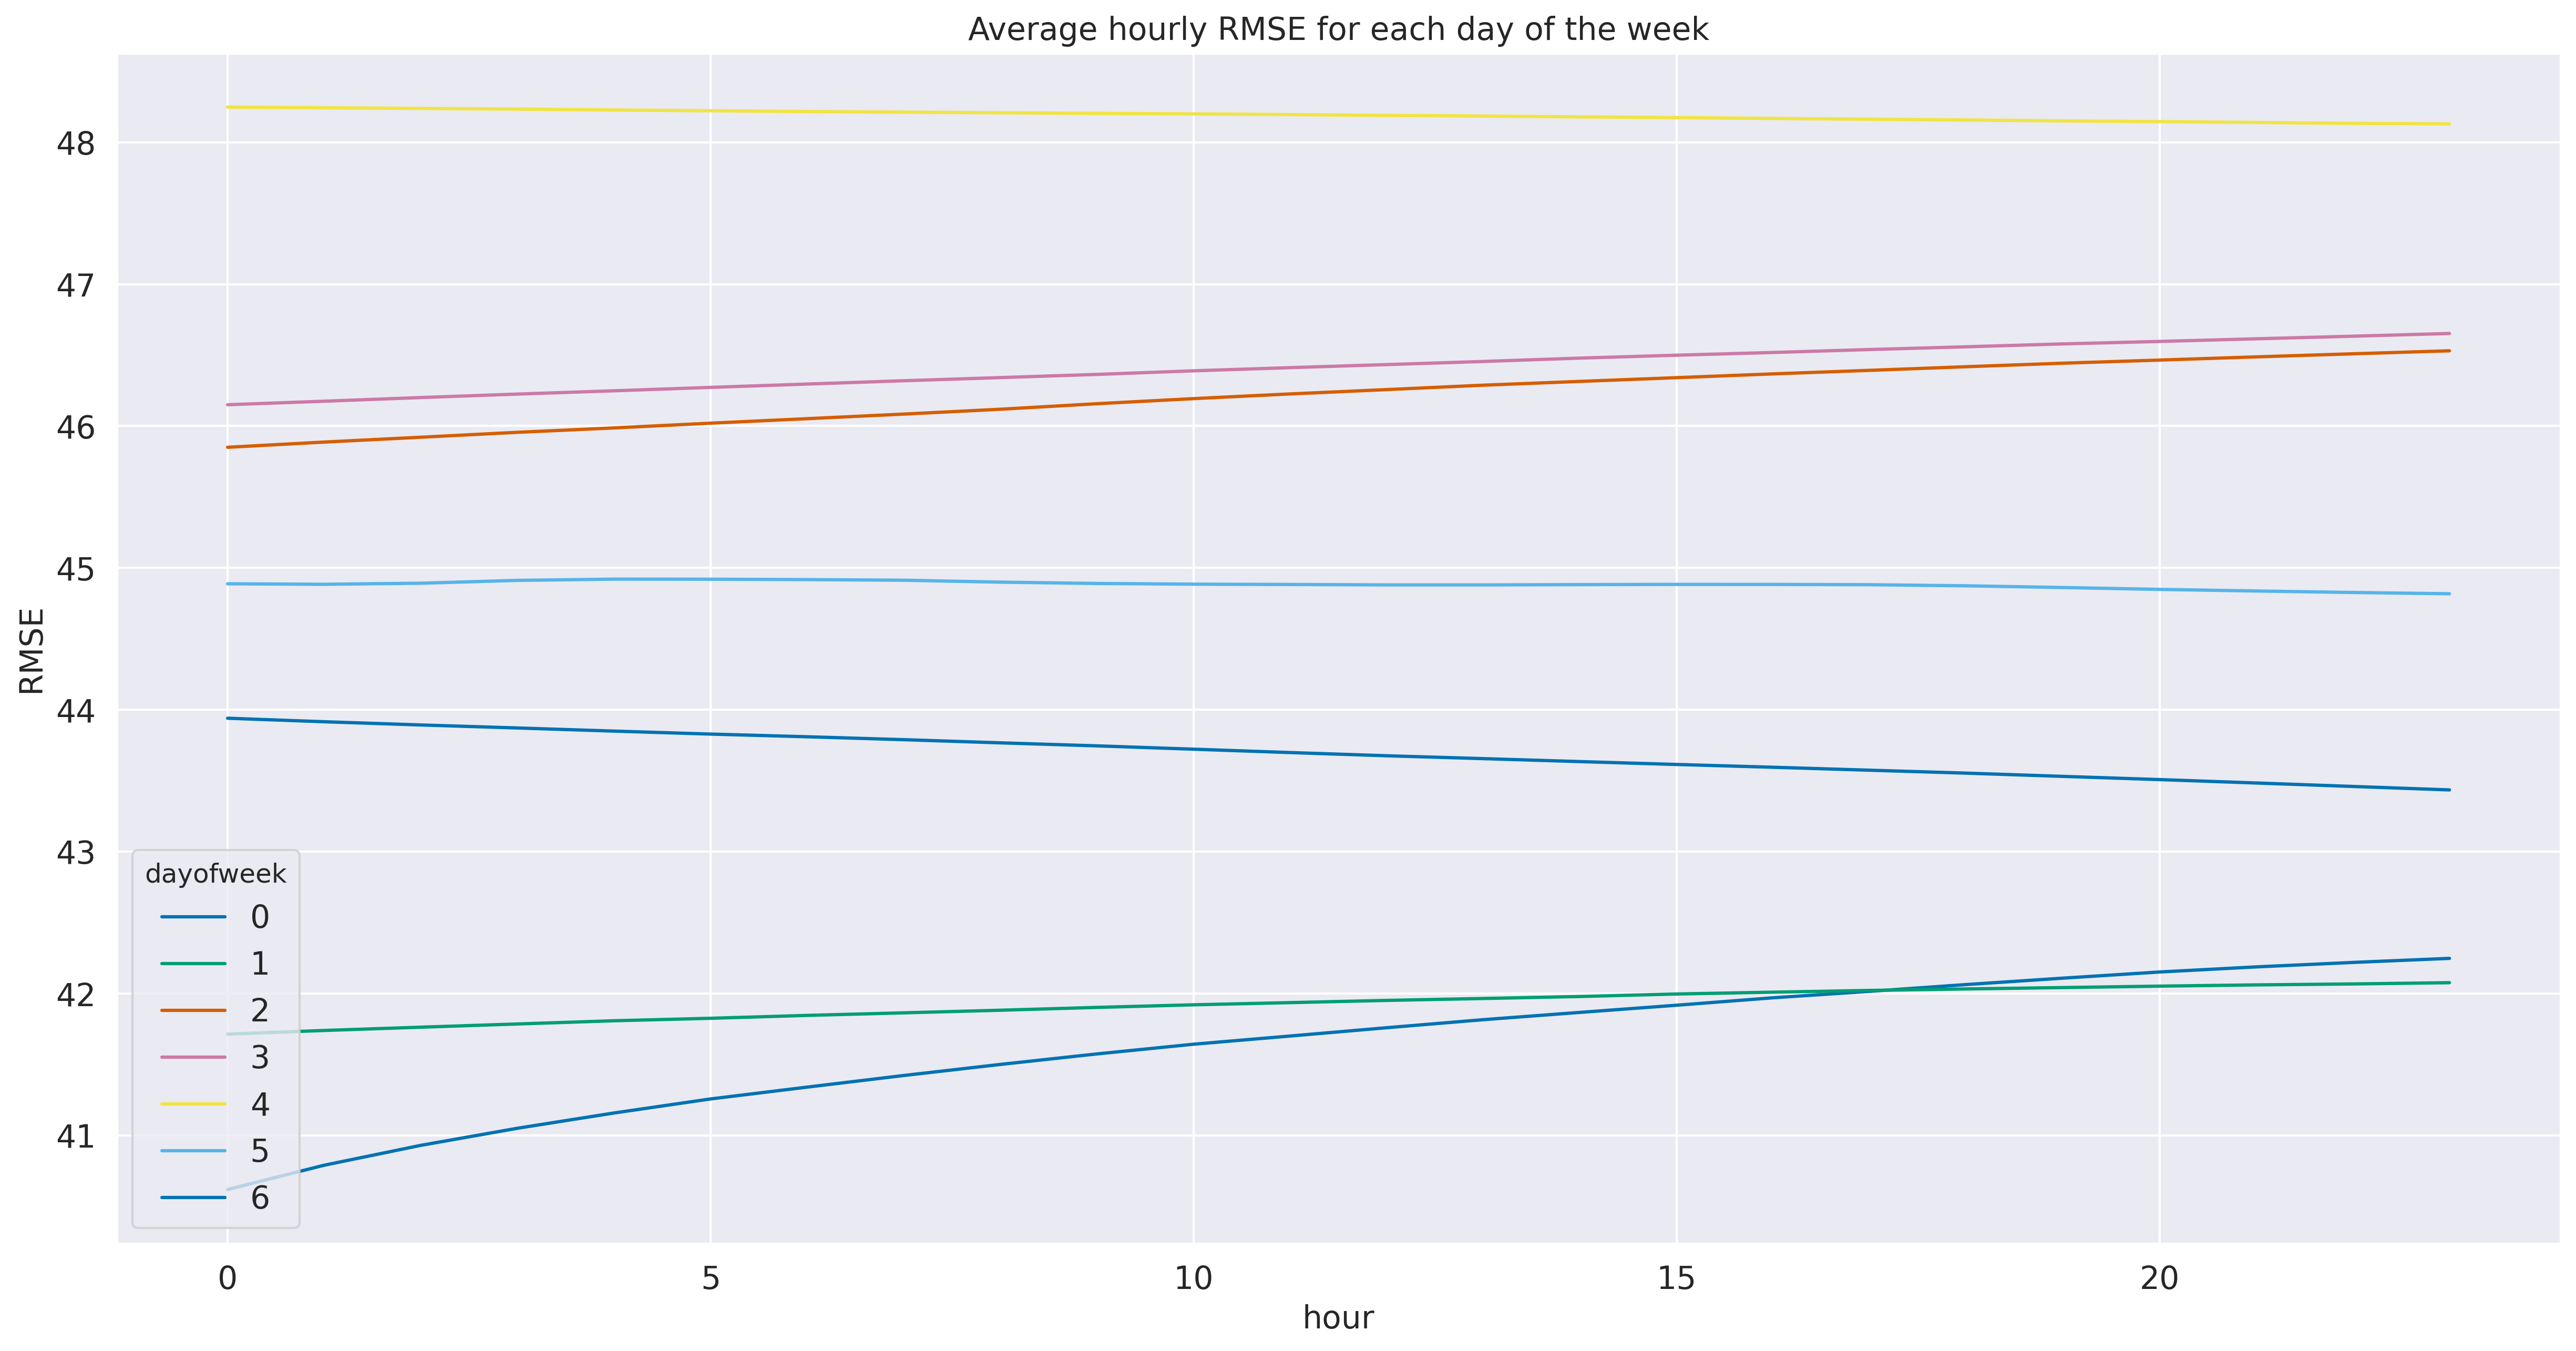

In [ ]:
hour_day = pd.pivot_table(data = preds_df, values="RMSE",
                            index = "hour", columns="dayofweek",
                            aggfunc="mean")
display(hour_day)
hour_day.plot()
plt.ylabel("RMSE")
plt.title("Average hourly RMSE for each day of the week")
plt.savefig(f'drive/My Drive/MONTA/Plots/DistLambda_LSTM Average hourly RMSE for each day.jpg')
plt.show()